In [1]:
#importing packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import os
import utils
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as stats_api
import pytz
pst_tz = pytz.timezone('America/Los_Angeles')

directory = 'C:/Users/madhu.kolli/Desktop/ECE 219/Project 5 Twitter/'
tweettags = ["gohawks", "gopatriots", "nfl", "patriots", "sb49", "superbowl"]

C:\Users\madhu.kolli\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
tweetfeatures = ['Number of tweets', 'Total number of retweets', 'Total number of followers',
                 'Maximum number of followers', 'Hour of the day', 'Total tweets by Author',
                 'Author Passivity', 'Impression Count', 'Ranking Score', 'Mention Count',
                 'Graph Density', 'Avg Graph Degree','urls','hashtags']

default_feature_count = 5 #number of tweets, retweets, followers, max followers and hour of the day
extra_feature_count = len(tweetfeatures)
start_time = datetime(2015, 2, 1, 8, 0, 0).replace(tzinfo=pst_tz)
end_time = datetime(2015, 2, 1, 20, 0, 0).replace(tzinfo=pst_tz)


class tweets():

    def get_feature_names(self):
        return tweetfeatures
    
    
    def scale_data(self, X):
        return StandardScaler().fit_transform(X)
        

    def cross_validation(self, X, y, model = stats_api.OLS, n_splits = 10):

        test_rmse, test_mae = [], []
        kf = KFold(n_splits = n_splits)

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if model == stats_api.OLS:
                lm = model(y_train, X_train).fit()
            else:
                lm = model().fit(X_train, y_train)

            y_pred = lm.predict(X_test)
            test_mae.append(mean_absolute_error(y_pred, y_test))
            test_rmse.append(mean_squared_error(y_pred, y_test))


        avg_rmse = np.mean(test_rmse)
        print("Average Mean Absolute Error - ", np.mean(test_mae))
        print("Average Mean Squared Error - ", avg_rmse)
        print("Average Root Mean Squared Error - ", np.sqrt(avg_rmse))

    def test_model(self, X_train, y_train, X_test, y_test, model):

        lm = model().fit(X_train, y_train)
        y_pred = lm.predict(X_test)

        print("Actual number of tweets in next hour  - ", y_test)
        print("Predicted number of tweets in next hour - ", y_pred)
        print("Average Mean Absolute Error - ", mean_absolute_error(y_pred, y_test))


    def get_X_y(self, args):
        """
        Takes the data frame with features and converts it to the right input X and output y formats
        Uses Grouper for separating the tweets by time period.

        Takes an argument window - this determines how many past hour features determine current output
        """


        df = args['features'].set_index('time')
        tweets_by_hour = df.groupby(pd.Grouper(freq='60Min'))
        # key as hour (totally 500+ hours), value as the list of all tweet data in that hour

        num_hours = len(tweets_by_hour)
        num_features = extra_feature_count if args['extra_features'] else default_feature_count

        X = np.zeros((num_hours, num_features))

        for i, (key, val) in enumerate(tweets_by_hour):

            features = [len(val), val.retweets.sum(), val.followers.sum(), val.followers.max(), key.hour]

            if args['extra_features']:
                features.extend([val.user_tweet_count.mean(),
                                val.passivity.sum(), val.impression_count.mean(),
                                val.ranking_score.mean(), val.mention_count.sum(),
                                val.density.sum(), val.degree.sum(),val.url_count.sum(),val.hashtag_count.sum()])

            X[i, :] = features

        window = args['window']
        y = X[:, 0][window:]
        # number of tweets is the output as well as the first feature - but have to shift by #window hours

        X = np.nan_to_num(X)
        X_window = np.zeros((num_hours - window, num_features * window))

        # previous window hours' data is the features for the current hour's number of tweets
        if args.get('avg_past_features',False):
            #average past 'window' hours features
            X_window = [np.mean(X[i:i+window, :], axis = 0) for i in range(num_hours - window)]

        else:
            #concatenate past 'window' hours features
            for i in range(num_hours - window):
                X_window[i, :] = np.concatenate([X[i+k, :] for k in range(window)])

        X_window = np.nan_to_num(X_window)

        #X_window = self.scale_data(X_window)
        #y = self.scale_data(y.reshape(-1,1))

        return X_window, y

    def format_date(self, date_string):

        return datetime.strptime(date_string, '%a %b %d %H:%M:%S %z %Y')


    def get_passivity(self, account_creation_date, tweet_date, tweets_posted):

        days_since_account_creation = (self.format_date(tweet_date) - self.format_date(account_creation_date)).days
        passivity = days_since_account_creation / (1 + tweets_posted)
        return passivity


    def get_features(self, args):
        """
        Gets the hashtag, type of model to fit the data.
        Passes the input to feature extraction methods and get the data required in right format
        """
        citation_date, followers, retweets, favorite_count, mention_count = [], [], [], [], []
        user_tweet_count, passivity, impression_count, ranking_score, user_id = [], [], [], [], []
        density, degree = [], []
        url_count,hashtag_count = [], []

        for tag in args['tweettags']:

            file_name = args.get('file_name') if args.get('file_name') else directory + 'tweets_#' + tag + '.txt'

            lines = open(file_name, 'r', encoding='utf8')

            for line in lines:
                tweet = json.loads(line)

                tweet_data = tweet['tweet']
                user_data = tweet_data['user']
                num_retweets = tweet['metrics']['citations']['total']
                mentions = len(tweet_data['entities']['user_mentions'])

                tweet_date = tweet['citation_date'] if args.get("citation_date", True) else tweet["firstpost_date"]

                citation_date.append(datetime.fromtimestamp(tweet_date, pst_tz))
                followers.append(tweet['author']['followers'])
                retweets.append(num_retweets)
                favorite_count.append(tweet_data['favorite_count'])
                mention_count.append(mentions)
                user_tweet_count.append(user_data['statuses_count'])
                impression_count.append(tweet['metrics']['impressions'])
                ranking_score.append(tweet['metrics']['ranking_score'])
                user_id.append(user_data['id'])
                passivity.append(self.get_passivity(user_data['created_at'], tweet_data['created_at'], user_data['statuses_count']))

                density.append(0 if num_retweets <= 1 else mentions / abs(num_retweets * (num_retweets - 1)))
                degree.append(0 if num_retweets <= 0 else (2 * mentions) / num_retweets)
                url_count.append(len(tweet['tweet']['entities']['urls']))
                hashtag_count.append(tweet['title'].count('#'))

        column_names = ['time', 'followers', 'retweets']
        features = [citation_date, followers, retweets]

        if args['extra_features']:
            column_names.extend(['favorite_count', 'user_tweet_count', 'passivity','impression_count',
                                 'ranking_score','user_id', 'mention_count', 'density', 'degree','url_count','hashtag_count'])
            features.extend([favorite_count, user_tweet_count, passivity, impression_count,
                             ranking_score, user_id, mention_count, density, degree,url_count,hashtag_count])

        df = pd.DataFrame(features)
        df = df.transpose()
        df.columns = column_names

        args['features'] = df

        return args


    def time_interval_model(self, features, model, cv = True):

        output = {}

        df = features["features"]

        features["features"] = df[df.time < start_time]
        output['X_bef'], output['y_bef'] = self.get_X_y(features)

        features["features"] = df[(df.time >= start_time) & (df.time <= end_time)]
        output['X_bet'], output['y_bet'] = self.get_X_y(features)

        features["features"] = df[df.time > end_time]
        output['X_aft'], output['y_aft'] = self.get_X_y(features)

        if cv:

            print("\nTime period before Feb 1 8am")
            self.cross_validation(output['X_bef'], output['y_bef'], model)

            print("\nTime period between Feb 1 8am and Feb 1 8pm")
            self.cross_validation(output['X_bet'], output['y_bet'], model)

            print("\nTime period after Feb 1 8pm")
            self.cross_validation(output['X_aft'], output['y_aft'], model)


        return output


    def collect_stats(self, hashtag):

        file_name = 'tweets_#' + hashtag + '.txt'
        citation_date, followers, retweets = [], [], []

        lines = open(directory + file_name, 'r', encoding='utf8')

        for i, line in enumerate(lines):
            tweet = json.loads(line)
            citation_date.append(datetime.fromtimestamp(tweet['citation_date'], pst_tz))
            followers.append(tweet['author']['followers'])
            retweets.append(tweet['metrics']['citations']['total'])

        df = pd.DataFrame(citation_date, columns=['time']).set_index('time')
        tweets_by_hour = df.groupby(pd.Grouper(freq='60Min'))
        count_by_hour = [len(val) for key, val in tweets_by_hour]


        total_hours = len(tweets_by_hour)

        print("Average number of tweets per hour", len(citation_date) / total_hours)
        print("Average number of followers - ", np.mean(followers))
        print("Average number of retweets - ", np.mean(retweets))

        if hashtag in ['superbowl', "nfl"]:
            plt.style.use('dark_background')
            
            plt.grid("true",color='black')
            plt.xlabel('Hours')
            plt.ylabel('Number of tweets')
            plt.title('Number of tweets per hour for ' + hashtag)
            plt.bar(range(len(tweets_by_hour.groups.keys())), count_by_hour)
            plt.show()


Linear Regression for  gohawks

Window =  1
Mean Squared Error -  581001.3083897438
Root Mean Squared Error -  762.2344182662862
Mean Absolute Error -  201.0650625269648
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     66.11
Date:                Mon, 11 Jun 2018   Prob (F-statistic):          4.97e-109
Time:                        12:03:06   Log-Likelihood:                -4655.9
No. Observations:                 578   AIC:                             9340.
Df Residuals:                     564   BIC:                             9401.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err       

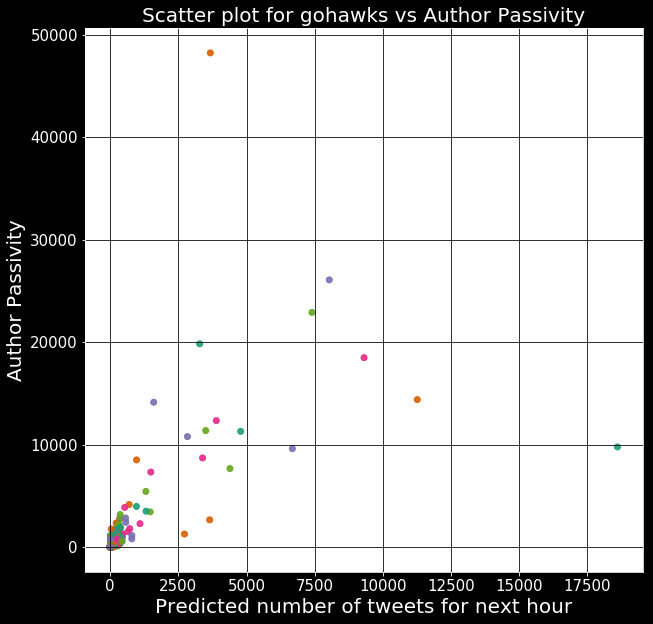

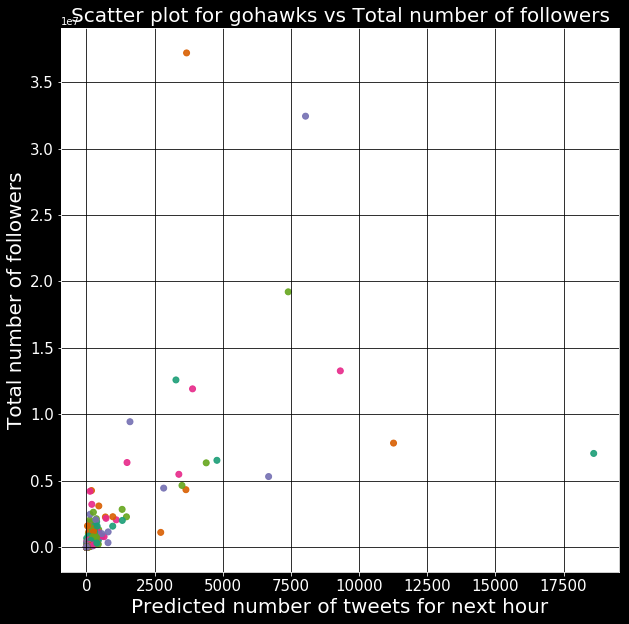

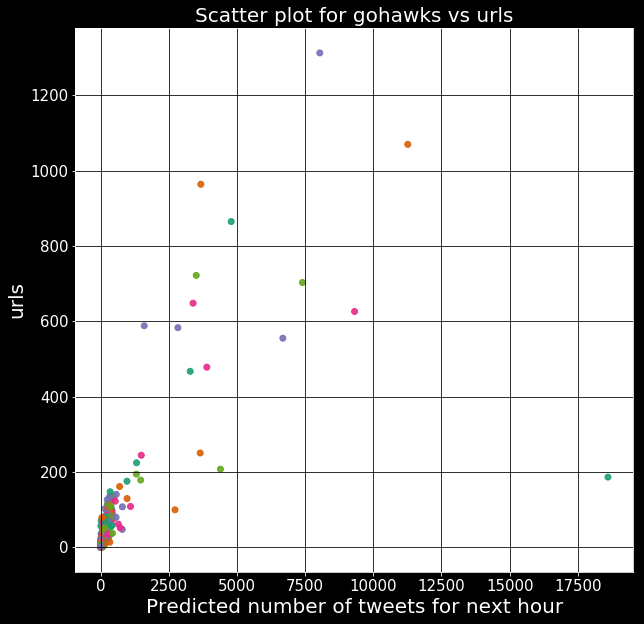


Linear Regression for  gopatriots

Window =  1
Mean Squared Error -  15698.689168555944
Root Mean Squared Error -  125.29440996531308
Mean Absolute Error -  33.94933432356585
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     153.9
Date:                Mon, 11 Jun 2018   Prob (F-statistic):          1.99e-181
Time:                        12:03:14   Log-Likelihood:                -3587.3
No. Observations:                 574   AIC:                             7203.
Df Residuals:                     560   BIC:                             7263.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err  

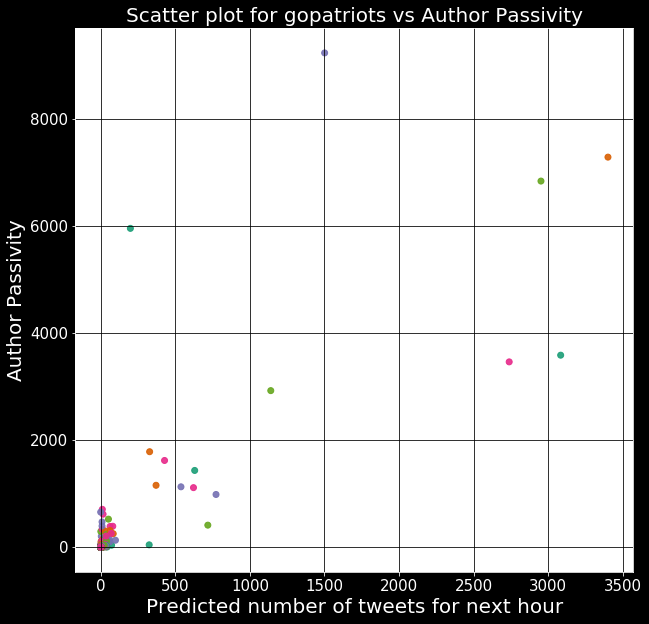

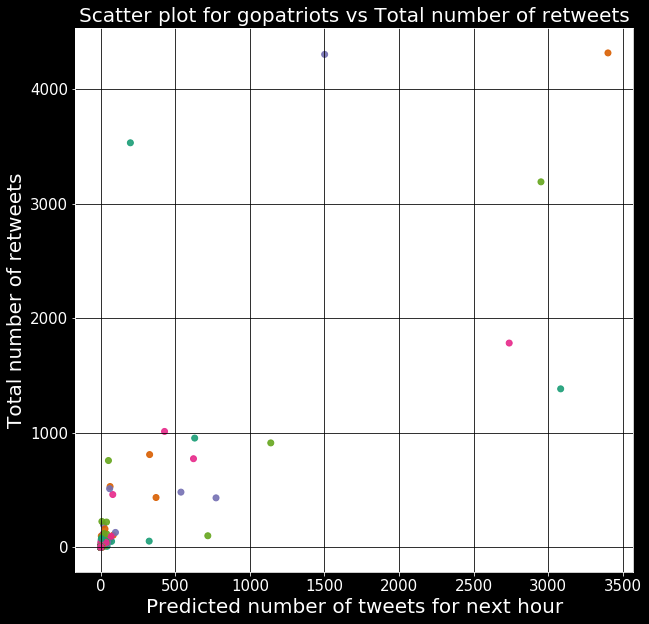

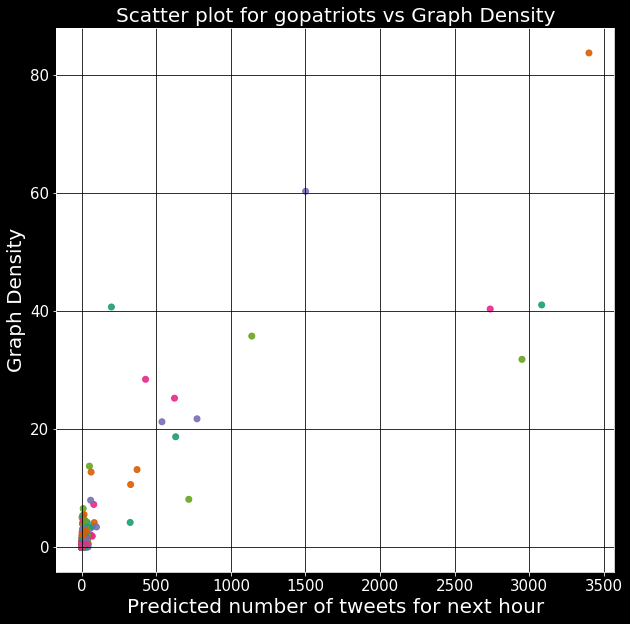


Linear Regression for  nfl

Window =  1
Mean Squared Error -  187138.28810058377
Root Mean Squared Error -  432.5948313382671
Mean Absolute Error -  178.97963373453726
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     131.0
Date:                Mon, 11 Jun 2018   Prob (F-statistic):          5.95e-168
Time:                        12:04:06   Log-Likelihood:                -4388.4
No. Observations:                 586   AIC:                             8805.
Df Residuals:                     572   BIC:                             8866.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err         

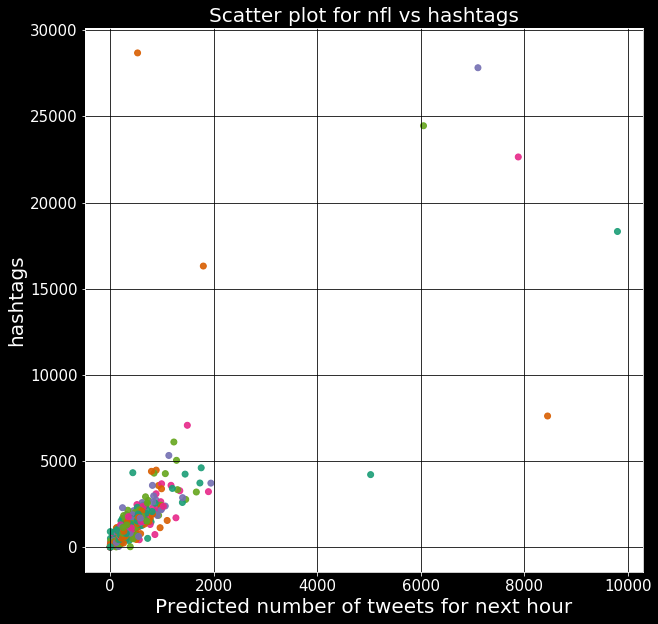

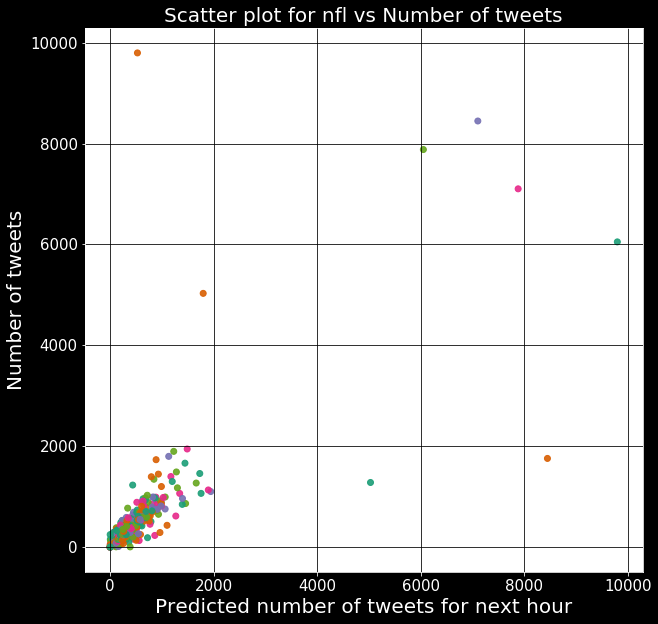

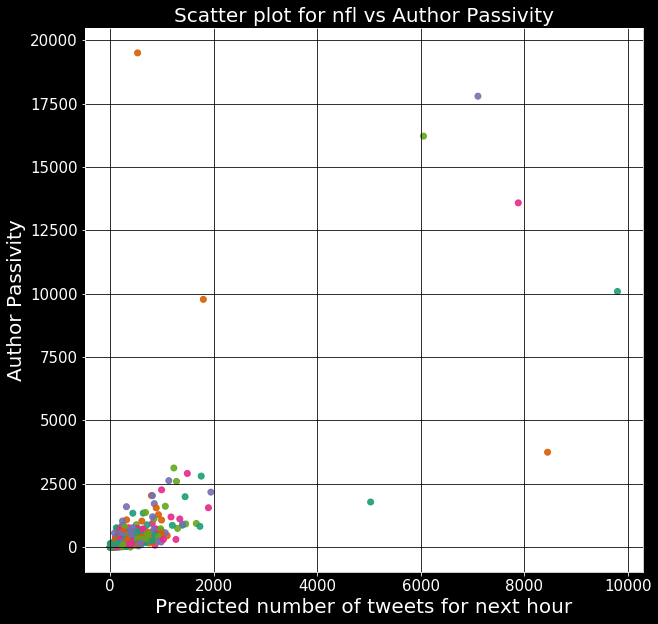


Linear Regression for  patriots

Window =  1
Mean Squared Error -  2851751.0502152573
Root Mean Squared Error -  1688.7128382928986
Mean Absolute Error -  614.4754551106303
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     191.1
Date:                Mon, 11 Jun 2018   Prob (F-statistic):          5.30e-205
Time:                        12:05:40   Log-Likelihood:                -5186.5
No. Observations:                 586   AIC:                         1.040e+04
Df Residuals:                     572   BIC:                         1.046e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err    

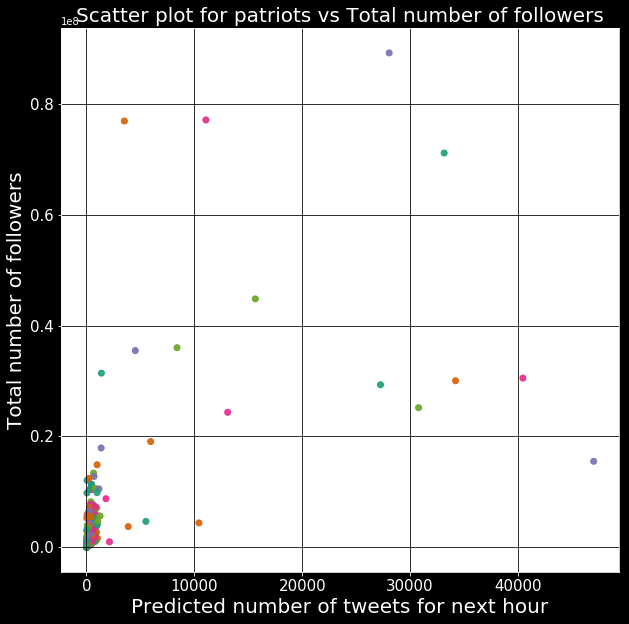

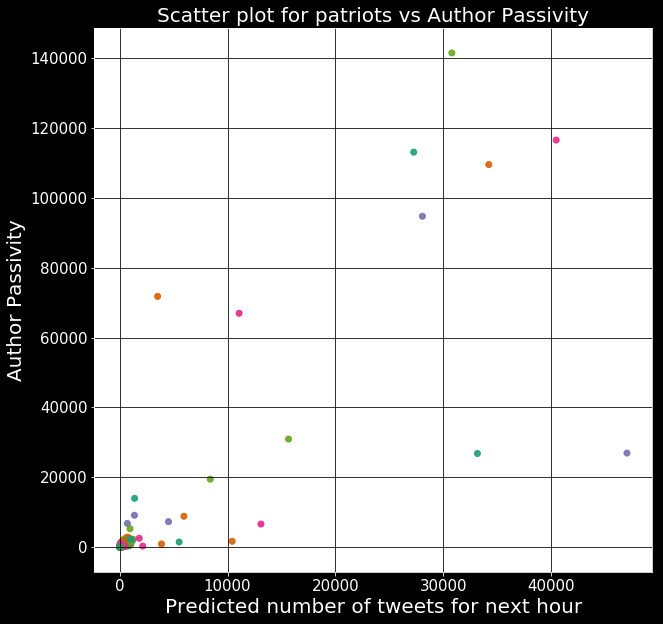

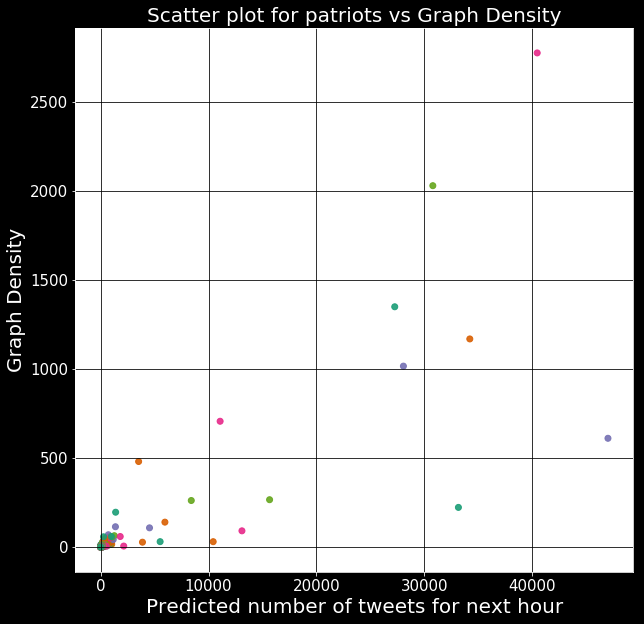


Linear Regression for  sb49

Window =  1
Mean Squared Error -  8505299.732159954
Root Mean Squared Error -  2916.3847023600906
Mean Absolute Error -  857.3355645512904
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     362.4
Date:                Mon, 11 Jun 2018   Prob (F-statistic):          2.87e-272
Time:                        12:08:16   Log-Likelihood:                -5469.1
No. Observations:                 582   AIC:                         1.097e+04
Df Residuals:                     568   BIC:                         1.103e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err         

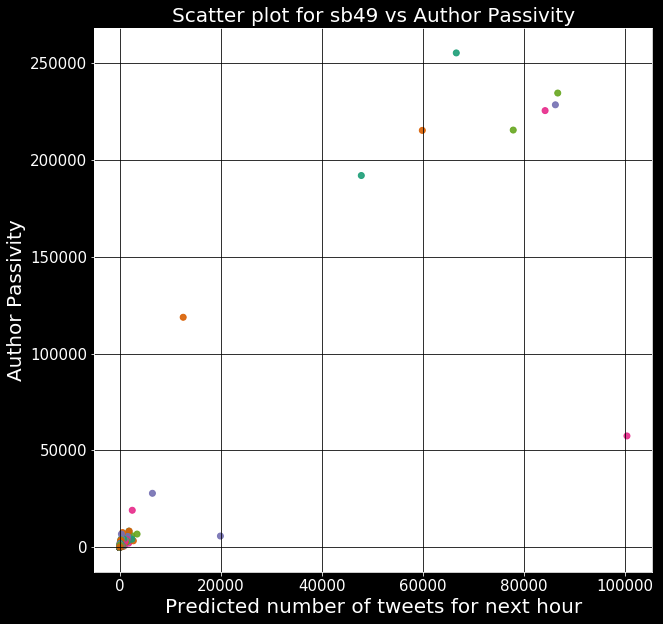

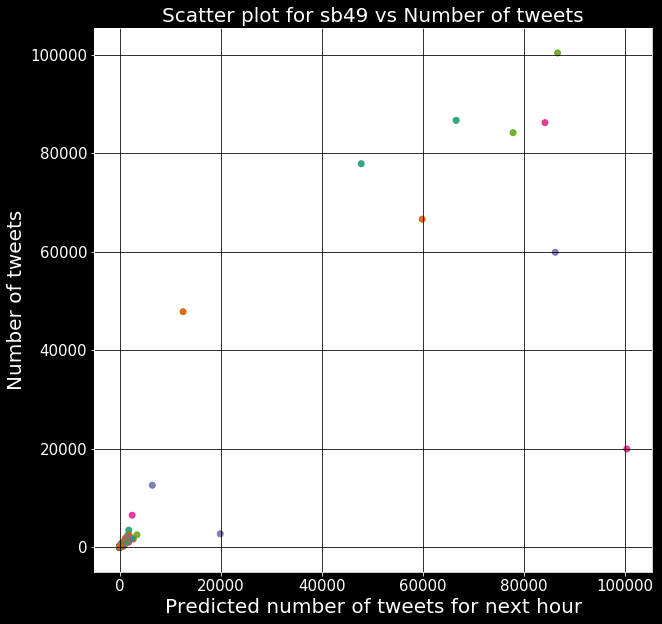

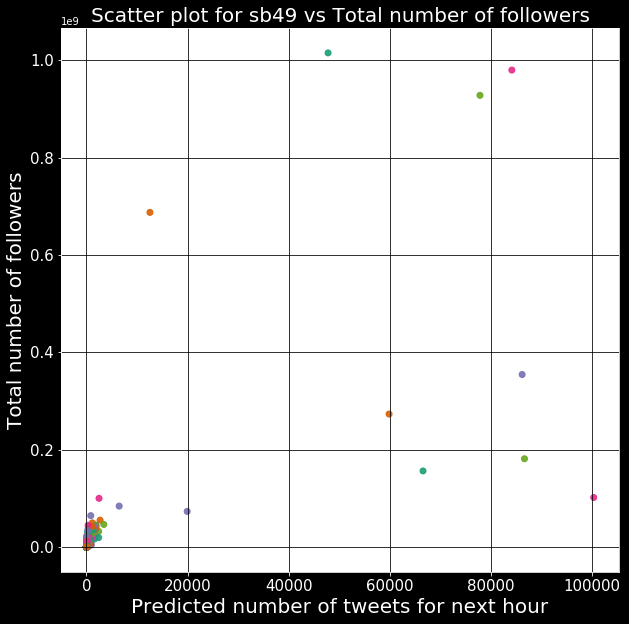


Linear Regression for  superbowl

Window =  1
Mean Squared Error -  26852087.843613353
Root Mean Squared Error -  5181.900022541284
Mean Absolute Error -  1646.10528791323
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     364.6
Date:                Mon, 11 Jun 2018   Prob (F-statistic):          3.77e-274
Time:                        12:12:41   Log-Likelihood:                -5843.5
No. Observations:                 586   AIC:                         1.172e+04
Df Residuals:                     572   BIC:                         1.178e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err     

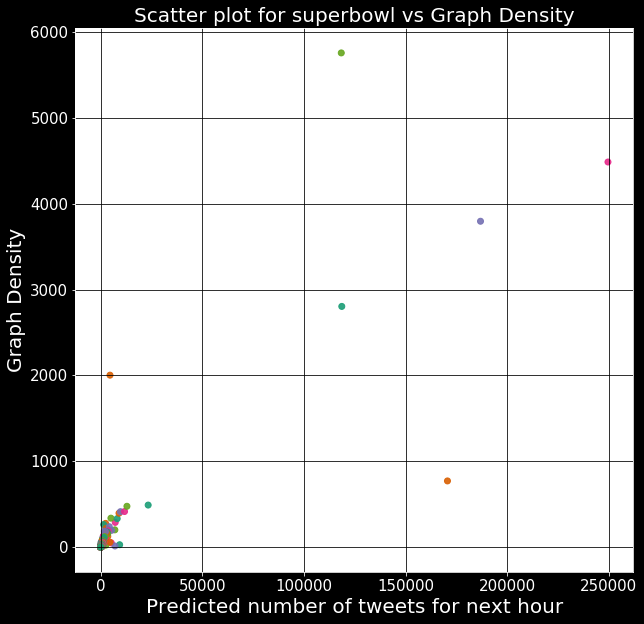

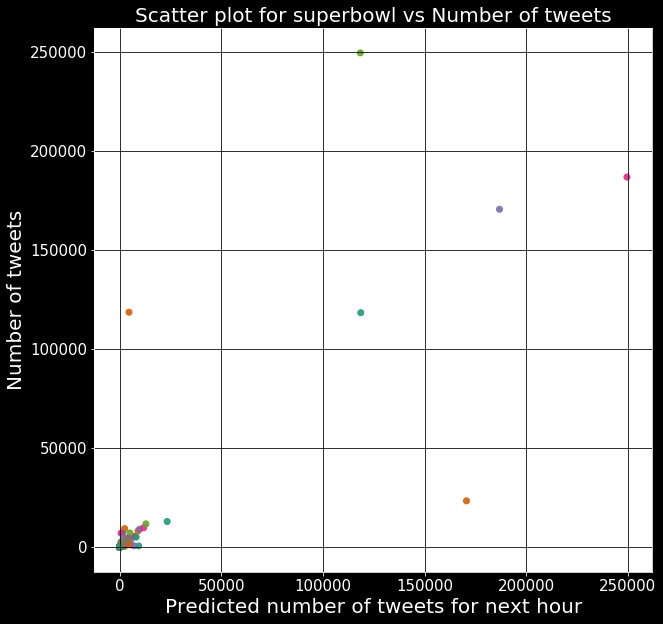

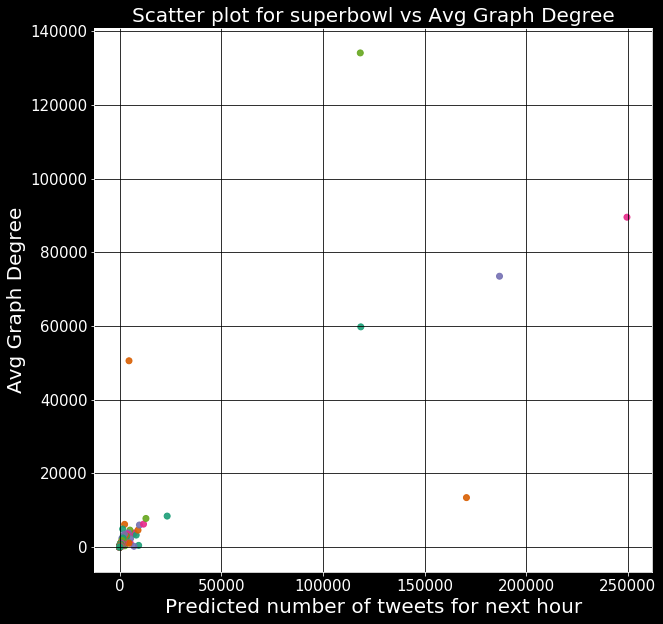

In [4]:
#q 4 and 5 
tweettags = ["gohawks", "gopatriots", "nfl", "patriots", "sb49", "superbowl"]
window = 1
avg_past_features = False
args = {"extra_features": True, "window": window, "avg_past_features": avg_past_features, "scale_input": False}
utils_obj = tweets()

for tag in tweettags:
    print("=" * 50)
    print("\nLinear Regression for ", tag)
    print("\nWindow = ", window)

    args["tweettags"] = [tag]
    features = utils_obj.get_features(args)
    X, y = utils_obj.get_X_y(features)

    predictor_model = stats_api.OLS(y, X).fit()
    mse = mean_squared_error(y, predictor_model.predict())

    print("Mean Squared Error - ", mse)
    print("Root Mean Squared Error - ", np.sqrt(mse))
    print("Mean Absolute Error - ", mean_absolute_error(y, predictor_model.predict()))
    print(predictor_model.summary())

    feature_names = utils_obj.get_feature_names()
    best_features_index = predictor_model.pvalues.argsort()[:3]
    print("Top 3 features are  - ", [feature_names[index] for index in best_features_index])
    
    colors = ['#1b9e77',
          '#d95f02',
          '#7570b3',
          '#e7298a',
          '#66a61e']
    
    for index in best_features_index:
        plt.figure(figsize=(10,10))
        plt.style.use('dark_background')
        plt.grid("true",color='black')
        ax = plt.gca()
        ax.set_facecolor('white')
        plt.title("Scatter plot for " + tag + " vs " + feature_names[index],fontsize=20)
        plt.xlabel("Predicted number of tweets for next hour",fontsize=20)
        plt.ylabel(feature_names[index],fontsize=20)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.scatter(y[:50000], X[:, index][:50000],color=colors,alpha=0.9)
        
        plt.show()
    